In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import pickle
import matplotlib.pyplot as plt

from imageio import imread
from PIL import Image
from imagenet_classes import class_names

- pretrained weight 불러오기

In [2]:
# 학습된 이미지의 RGB평균
image_mean = [103.939, 116.779, 123.68]
# 학습된 target class
n_labels = 1000
# network weight
pretrained_weights = np.load('vgg16CAM.npy', encoding='latin1')

---

- 이미지 전처리
    - 학습 네트워크의 이미지 사이즈는 $224 \times 224$ 로 고정되어 있다.

In [3]:
img = imread('tmp.jpeg')
print('shape:',img.shape)

shape: (960, 720, 3)


(-0.5, 223.5, 223.5, -0.5)

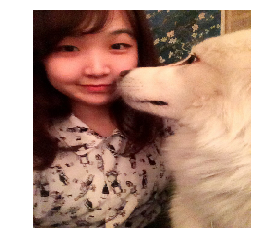

In [4]:
img = imread('tmp.jpeg')
# to PIL
img = Image.fromarray(img).resize((224, 224))
plt.imshow(img)
plt.axis('off')

In [5]:
# to numpy
img = np.array(img)
img.shape

(224, 224, 3)

---

- 텐서 그래프 생성

In [6]:
tf.reset_default_graph()

In [7]:
# Define Placeholders for images and labels
images_tf = tf.placeholder(tf.float32, [None, 224, 224, 3], name="images")
labels_tf = tf.placeholder(tf.int32, [None], name='labels')

In [8]:
r, g, b = tf.split(images_tf,[1,1,1] , 3)
print(r)
print(g)
print(b)

Tensor("split:0", shape=(?, 224, 224, 1), dtype=float32)
Tensor("split:1", shape=(?, 224, 224, 1), dtype=float32)
Tensor("split:2", shape=(?, 224, 224, 1), dtype=float32)


- $r,g,b$ centering

In [9]:
image = tf.concat([b-image_mean[0],g-image_mean[1], r-image_mean[2]],3)
image

<tf.Tensor 'concat:0' shape=(?, 224, 224, 3) dtype=float32>

In [10]:
def conv_layer(inputs, name, stride = 1):

    with tf.variable_scope(name, reuse = tf.AUTO_REUSE):
        
        # pre-trained network
        w = pretrained_weights.item()[name]['weights']
        b = pretrained_weights.item()[name]['biases']
        
        conv_weights = tf.get_variable(
                "W",
                shape=w.shape,
                initializer=tf.constant_initializer(w)
                )
        conv_biases = tf.get_variable(
                "b",
                shape=b.shape,
                initializer=tf.constant_initializer(b)
                )

        conv = tf.nn.conv2d(inputs, conv_weights, [1,stride,stride,1], padding='SAME')
        bias = tf.nn.bias_add( conv, conv_biases )
        relu = tf.nn.relu( bias, name=name )

    return relu

- Conv1_1 output 계산 식: $(224-1)/1 +1 = 224$

In [11]:
relu1_1 = conv_layer(image, "conv1_1" )
relu1_1

<tf.Tensor 'conv1_1/conv1_1:0' shape=(?, 224, 224, 64) dtype=float32>

- Conv1_2 output 계산 식: $(224-1)/1 +1 = 224$

In [12]:
relu1_2 = conv_layer(relu1_1, "conv1_2" )
relu1_2

<tf.Tensor 'conv1_2/conv1_2:0' shape=(?, 224, 224, 64) dtype=float32>

- pool1 output 계산 식: $(224-2)/2 +1 = 112$

In [13]:
pool1 = tf.nn.max_pool(relu1_2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],
                       padding='SAME', name='pool1')
pool1

<tf.Tensor 'pool1:0' shape=(?, 112, 112, 64) dtype=float32>

- Conv2_1 output 계산 식: $(112-1)/1 +1 = 112$

In [14]:
relu2_1 = conv_layer(pool1, "conv2_1")   
relu2_1

<tf.Tensor 'conv2_1/conv2_1:0' shape=(?, 112, 112, 128) dtype=float32>

- Conv2_2 output 계산 식: $(112-1)/1 +1 = 112$

In [15]:
relu2_2 = conv_layer(relu2_1, "conv2_2")
relu2_2

<tf.Tensor 'conv2_2/conv2_2:0' shape=(?, 112, 112, 128) dtype=float32>

- pool2 output 계산 식: $(112-2)/2 +1 = 56$

In [16]:
pool2 = tf.nn.max_pool(relu2_2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],
                       padding='SAME', name='pool2')
pool2

<tf.Tensor 'pool2:0' shape=(?, 56, 56, 128) dtype=float32>

- Conv3_1 output 계산 식: $(56-1)/1 +1 = 56$

In [17]:
relu3_1 = conv_layer(pool2, "conv3_1")
relu3_1

<tf.Tensor 'conv3_1/conv3_1:0' shape=(?, 56, 56, 256) dtype=float32>

- Conv3_2 output 계산 식: $(56-1)/1 +1 = 56$

In [18]:
relu3_2 = conv_layer(relu3_1, "conv3_2")
relu3_2

<tf.Tensor 'conv3_2/conv3_2:0' shape=(?, 56, 56, 256) dtype=float32>

- Conv3_3 output 계산 식: $(56-1)/1 +1 = 56$

In [19]:
relu3_3 = conv_layer(relu3_2, "conv3_3")
relu3_3

<tf.Tensor 'conv3_3/conv3_3:0' shape=(?, 56, 56, 256) dtype=float32>

- pool3 output 계산 식: $(56-2)/2 +1 = 28$

In [20]:
pool3 = tf.nn.max_pool(relu3_3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],
                       padding='SAME', name='pool3')
pool3

<tf.Tensor 'pool3:0' shape=(?, 28, 28, 256) dtype=float32>

- Conv4_1 output 계산 식: $(28-1)/1 +1 = 28$

In [21]:
relu4_1 = conv_layer(pool3, "conv4_1")
relu4_1

<tf.Tensor 'conv4_1/conv4_1:0' shape=(?, 28, 28, 512) dtype=float32>

- Conv4_2 output 계산 식: $(28-1)/1 +1 = 28$

In [22]:
relu4_2 = conv_layer(relu4_1, "conv4_2")
relu4_2

<tf.Tensor 'conv4_2/conv4_2:0' shape=(?, 28, 28, 512) dtype=float32>

- Conv4_3 output 계산 식: $(28-1)/1 +1 = 28$

In [23]:
relu4_3 = conv_layer(relu4_2, "conv4_3")
relu4_3

<tf.Tensor 'conv4_3/conv4_3:0' shape=(?, 28, 28, 512) dtype=float32>

- pool4 output 계산 식: $(28-2)/2 +1 = 14$

In [24]:
pool4 = tf.nn.max_pool(relu4_3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],
                       padding='SAME', name='pool4')
pool4

<tf.Tensor 'pool4:0' shape=(?, 14, 14, 512) dtype=float32>

- Conv5_1 output 계산 식: $(14-1)/1 +1 = 14$

In [25]:
relu5_1 = conv_layer(pool4, "conv5_1")
relu5_1

<tf.Tensor 'conv5_1/conv5_1:0' shape=(?, 14, 14, 512) dtype=float32>

- Conv5_2 output 계산 식: $(14-1)/1 +1 = 14$

In [26]:
relu5_2 = conv_layer(relu5_1, "conv5_2")
relu5_2

<tf.Tensor 'conv5_2/conv5_2:0' shape=(?, 14, 14, 512) dtype=float32>

- Conv5_3 output 계산 식: $(14-1)/1 +1 = 14$

In [27]:
relu5_3 = conv_layer(relu5_2, "conv5_3")
relu5_3

<tf.Tensor 'conv5_3/conv5_3:0' shape=(?, 14, 14, 512) dtype=float32>

--- 

- CAM(last) conv

In [28]:
w = pretrained_weights.item()['CAM_conv']['weights']
b = pretrained_weights.item()['CAM_conv']['biases']
print('weight:',w.shape)
print('bias:',b.shape)

weight: (3, 3, 256, 1024)
bias: (1024,)


In [29]:
print(w.shape)
print(b.shape)

(3, 3, 256, 1024)
(1024,)


In [30]:
with tf.variable_scope('CAM_conv', reuse = tf.AUTO_REUSE):
    conv_weights = tf.get_variable(
                    "W",
                    shape=w.shape,
                    initializer=tf.constant_initializer(w)
                    )
    print(conv_weights)

<tf.Variable 'CAM_conv/W:0' shape=(3, 3, 256, 1024) dtype=float32_ref>


In [31]:
with tf.variable_scope('CAM_conv', reuse = tf.AUTO_REUSE):
    conv_biases = tf.get_variable(
                    "b",
                    shape=b.shape,
                    initializer=tf.constant_initializer(b)
                    )
    print(conv_biases)

<tf.Variable 'CAM_conv/b:0' shape=(1024,) dtype=float32_ref>


- caffe에서 구현된 CAM_conv의 pre-trained weight는 두 종류의 커널을 concat한 것임

```python
{conv_weights: (256, 1024)} = {kernel1: (256, 512), kernel2: (256, 512)}
```

- conv 5_3 output을 두개의 커널을 사용하여 연산하기 위해 channel의 수를 반씩 나눔

```python
{relu5_3: (512)} = {group1: (256), group2: (256)}
```


In [32]:
kernel1, kernel2 = tf.split(conv_weights, num_or_size_splits=2, axis=3)
print(kernel1)
print(kernel2)

Tensor("split_1:0", shape=(3, 3, 256, 512), dtype=float32)
Tensor("split_1:1", shape=(3, 3, 256, 512), dtype=float32)


In [33]:
group1, group2 = tf.split(relu5_3, num_or_size_splits=2, axis=3)
print(group1)
print(group2)

Tensor("split_2:0", shape=(?, 14, 14, 256), dtype=float32)
Tensor("split_2:1", shape=(?, 14, 14, 256), dtype=float32)


- group_1 output 계산 식: $(14-1)/1 +1 = 14$

In [34]:
conv_grp1 = tf.nn.conv2d(group1, kernel1, [1,1,1,1], padding='SAME')
conv_grp1

<tf.Tensor 'Conv2D:0' shape=(?, 14, 14, 512) dtype=float32>

- group_2 output 계산 식: $(14-1)/1 +1 = 14$

In [35]:
conv_grp2 = tf.nn.conv2d(group2, kernel2, [1,1,1,1], padding='SAME')
conv_grp2

<tf.Tensor 'Conv2D_1:0' shape=(?, 14, 14, 512) dtype=float32>

In [36]:
conv_output = tf.concat ([conv_grp1, conv_grp2], axis = 3)
conv_output

<tf.Tensor 'concat_1:0' shape=(?, 14, 14, 1024) dtype=float32>

- Conv6: global average pooling이 사용되기 전 Conv로 시각화가 이루어지는 feature map 

In [37]:
conv6 = tf.nn.bias_add(conv_output, conv_biases)
conv6

<tf.Tensor 'BiasAdd:0' shape=(?, 14, 14, 1024) dtype=float32>

In [38]:
gap = tf.reduce_mean(conv6, axis=[1,2])
gap

<tf.Tensor 'Mean:0' shape=(?, 1024) dtype=float32>

In [39]:
gap = tf.nn.dropout(gap, keep_prob=1.0)
gap

<tf.Tensor 'Mean:0' shape=(?, 1024) dtype=float32>

---

- FcL

In [40]:
w = pretrained_weights.item()['CAM_fc']['weights']
b = pretrained_weights.item()['CAM_fc']['biases']
print('weight:',w.shape)
print('bias:',b.shape)

weight: (1024, 1000)
bias: (1000,)


In [41]:
with tf.variable_scope("CAM_fc",reuse=tf.AUTO_REUSE):
    gap_w = tf.get_variable(
            "W",
            shape=w.shape,
            initializer=tf.constant_initializer(w)
            )
    print(gap_w)

<tf.Variable 'CAM_fc/W:0' shape=(1024, 1000) dtype=float32_ref>


In [42]:
output = tf.matmul(gap, gap_w)

---

In [43]:
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess=tf.Session(config = config)

In [44]:
sess.run(tf.global_variables_initializer())

In [45]:
fmaps = tf.identity(conv6)
fmaps

<tf.Tensor 'Identity:0' shape=(?, 14, 14, 1024) dtype=float32>

In [46]:
output

<tf.Tensor 'MatMul:0' shape=(?, 1000) dtype=float32>

- batch size axis 추가

In [47]:
img.shape

(224, 224, 3)

- 시각화 할 conv와 class probability를 계산할 op 수행

In [48]:
fmaps_val, output_val= sess.run([fmaps, output], 
                                feed_dict={images_tf: np.expand_dims(img, axis = 0)}
                               )  

- $(1,1000)$으로 확률로 구성된 matrix에서 가장 확률이 큰 3개의 class 선택 
- label_1: 가장 확률이 높은 class
- label_2: 두번째로 확률이 높은 class

In [49]:
sorted_output = (output_val.argsort(axis=1)[:,-3:])
label_1 = sorted_output[:,-1] 
label_2 = sorted_output[:,-2] 

---

# 시각화

- squeeze: $(1,3) \rightarrow (3,)$

In [50]:
sorted_output = np.squeeze(sorted_output)
sorted_output.shape

(3,)

In [51]:
height = 224
width = 224
num_fmaps = 1024

In [52]:
fmaps

<tf.Tensor 'Identity:0' shape=(?, 14, 14, 1024) dtype=float32>

In [53]:
fmaps_resized = tf.image.resize_bilinear( fmaps, [height, width] )
fmaps_resized

<tf.Tensor 'ResizeBilinear:0' shape=(?, 224, 224, 1024) dtype=float32>

In [54]:
with tf.variable_scope("CAM_fc", reuse=True):
    print(tf.get_variable("W"))

<tf.Variable 'CAM_fc/W:0' shape=(1024, 1000) dtype=float32_ref>


In [55]:
with tf.variable_scope("CAM_fc", reuse=True):
    print(tf.transpose(tf.get_variable("W")))

Tensor("CAM_fc_2/transpose:0", shape=(1000, 1024), dtype=float32)


- labels_tf(레이블)에 연결된 Conv6 feature map(1024)을 선택

In [56]:
labels_tf

<tf.Tensor 'labels:0' shape=(?,) dtype=int32>

In [57]:
with tf.variable_scope("CAM_fc", reuse=True):
    label_w = tf.gather(tf.transpose(tf.get_variable("W")), labels_tf)
    print(label_w)

Tensor("CAM_fc_3/GatherV2:0", shape=(?, 1024), dtype=float32)


- reshape: $(?, 1024) \rightarrow (?, 1024, 1)$

In [58]:
with tf.variable_scope("CAM_fc", reuse=True):
    label_w = tf.reshape( label_w, [-1, num_fmaps, 1] )
    print(label_w)

Tensor("CAM_fc_4/Reshape:0", shape=(?, 1024, 1), dtype=float32)


In [59]:
fmaps_resized = tf.reshape(fmaps_resized, [-1, height*width, num_fmaps])
fmaps_resized

<tf.Tensor 'Reshape:0' shape=(?, 50176, 1024) dtype=float32>

$ (?, 50176, 1024) \times  (?, 1024, 1) \rightarrow (?, 50176, 1)$

In [60]:
classmap = tf.matmul(fmaps_resized, label_w )
classmap

<tf.Tensor 'MatMul_1:0' shape=(?, 50176, 1) dtype=float32>

In [61]:
classmap = tf.reshape( classmap, [-1, height, width] )
classmap

<tf.Tensor 'Reshape_1:0' shape=(?, 224, 224) dtype=float32>

In [62]:
classmap_1 = sess.run(classmap, feed_dict={ labels_tf: label_1, fmaps: fmaps_val})
classmap_2 = sess.run(classmap, feed_dict={ labels_tf: label_2, fmaps: fmaps_val})

$(1, 224, 224) \rightarrow (224, 224)$

In [63]:
cmap_1 = np.squeeze(classmap_1, axis=0)
cmap_2 = np.squeeze(classmap_2, axis=0)

In [64]:
def normalize(img):
    """Normalize the image range for visualization"""
    return np.uint8((img - img.min()) / (img.max()-img.min())*255)

(-0.5, 223.5, 223.5, -0.5)

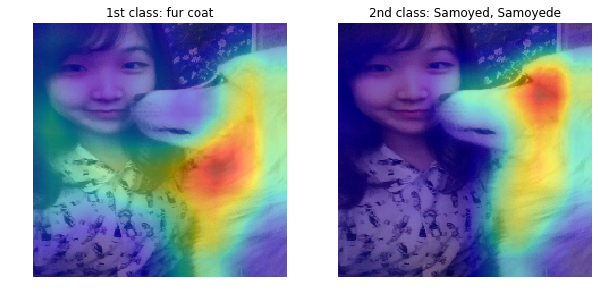

In [65]:
fig, axs = plt.subplots(1,2, figsize=(10,10))
axs[0].imshow(img)
axs[0].imshow(normalize(cmap_1), cmap=plt.cm.jet, alpha=0.5, interpolation='nearest')
axs[0].set_title('1st class: %s' %class_names[sorted_output[-1]])
axs[0].axis('off')

axs[1].imshow(img)
axs[1].imshow(normalize(cmap_2), cmap=plt.cm.jet, alpha=0.5, interpolation='nearest')
axs[1].set_title('2nd class: %s' %class_names[sorted_output[-2]])
axs[1].axis('off')

---

- fine-tunning

In [67]:
loss_tf = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=output, labels= labels_tf ), name='loss_tf')
loss_tf

<tf.Tensor 'loss_tf:0' shape=() dtype=float32>

In [68]:
tf.trainable_variables() 

[<tf.Variable 'conv1_1/W:0' shape=(3, 3, 3, 64) dtype=float32_ref>,
 <tf.Variable 'conv1_1/b:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'conv1_2/W:0' shape=(3, 3, 64, 64) dtype=float32_ref>,
 <tf.Variable 'conv1_2/b:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'conv2_1/W:0' shape=(3, 3, 64, 128) dtype=float32_ref>,
 <tf.Variable 'conv2_1/b:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'conv2_2/W:0' shape=(3, 3, 128, 128) dtype=float32_ref>,
 <tf.Variable 'conv2_2/b:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'conv3_1/W:0' shape=(3, 3, 128, 256) dtype=float32_ref>,
 <tf.Variable 'conv3_1/b:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'conv3_2/W:0' shape=(3, 3, 256, 256) dtype=float32_ref>,
 <tf.Variable 'conv3_2/b:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'conv3_3/W:0' shape=(3, 3, 256, 256) dtype=float32_ref>,
 <tf.Variable 'conv3_3/b:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'conv4_1/W:0' shape=(3, 3, 256, 512) dtype=float32_ref>,
 <tf.Variable

- filter의 결과값은 한번 사용되면 빈 값이 되는 것을 주의

In [111]:
weights_only = filter( lambda x: x.name.endswith('W:0'), tf.trainable_variables() )
list(weights_only)

[<tf.Variable 'conv1_1/W:0' shape=(3, 3, 3, 64) dtype=float32_ref>,
 <tf.Variable 'conv1_2/W:0' shape=(3, 3, 64, 64) dtype=float32_ref>,
 <tf.Variable 'conv2_1/W:0' shape=(3, 3, 64, 128) dtype=float32_ref>,
 <tf.Variable 'conv2_2/W:0' shape=(3, 3, 128, 128) dtype=float32_ref>,
 <tf.Variable 'conv3_1/W:0' shape=(3, 3, 128, 256) dtype=float32_ref>,
 <tf.Variable 'conv3_2/W:0' shape=(3, 3, 256, 256) dtype=float32_ref>,
 <tf.Variable 'conv3_3/W:0' shape=(3, 3, 256, 256) dtype=float32_ref>,
 <tf.Variable 'conv4_1/W:0' shape=(3, 3, 256, 512) dtype=float32_ref>,
 <tf.Variable 'conv4_2/W:0' shape=(3, 3, 512, 512) dtype=float32_ref>,
 <tf.Variable 'conv4_3/W:0' shape=(3, 3, 512, 512) dtype=float32_ref>,
 <tf.Variable 'conv5_1/W:0' shape=(3, 3, 512, 512) dtype=float32_ref>,
 <tf.Variable 'conv5_2/W:0' shape=(3, 3, 512, 512) dtype=float32_ref>,
 <tf.Variable 'conv5_3/W:0' shape=(3, 3, 512, 512) dtype=float32_ref>,
 <tf.Variable 'CAM_conv/W:0' shape=(3, 3, 256, 1024) dtype=float32_ref>,
 <tf.Varia

In [113]:
weights_only = filter( lambda x: x.name.endswith('W:0'), tf.trainable_variables() )
[tf.nn.l2_loss(x) for x in list(weights_only)]

[<tf.Tensor 'L2Loss_90:0' shape=() dtype=float32>,
 <tf.Tensor 'L2Loss_91:0' shape=() dtype=float32>,
 <tf.Tensor 'L2Loss_92:0' shape=() dtype=float32>,
 <tf.Tensor 'L2Loss_93:0' shape=() dtype=float32>,
 <tf.Tensor 'L2Loss_94:0' shape=() dtype=float32>,
 <tf.Tensor 'L2Loss_95:0' shape=() dtype=float32>,
 <tf.Tensor 'L2Loss_96:0' shape=() dtype=float32>,
 <tf.Tensor 'L2Loss_97:0' shape=() dtype=float32>,
 <tf.Tensor 'L2Loss_98:0' shape=() dtype=float32>,
 <tf.Tensor 'L2Loss_99:0' shape=() dtype=float32>,
 <tf.Tensor 'L2Loss_100:0' shape=() dtype=float32>,
 <tf.Tensor 'L2Loss_101:0' shape=() dtype=float32>,
 <tf.Tensor 'L2Loss_102:0' shape=() dtype=float32>,
 <tf.Tensor 'L2Loss_103:0' shape=() dtype=float32>,
 <tf.Tensor 'L2Loss_104:0' shape=() dtype=float32>]

In [110]:
weights_only = filter( lambda x: x.name.endswith('W:0'), tf.trainable_variables() )
weight_decay = tf.reduce_sum(tf.stack([tf.nn.l2_loss(x) for x in weights_only])) * 0.0005 # decay rate
weight_decay

<tf.Tensor 'mul_3:0' shape=() dtype=float32>

In [105]:
loss_tf += weight_decay

- 위 loss를 손실함수로 두고 학습하면 된다.